In [47]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    ExtraTreesClassifier,
    GradientBoostingClassifier,
    HistGradientBoostingClassifier,
    RandomForestClassifier,
    StackingClassifier,
    VotingClassifier,
)
from sklearn.metrics import accuracy_score, f1_score, make_scorer
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

sns.set_theme(style="white", palette="viridis")
pd.set_option("display.max_columns", None)
plt.style.use("fivethirtyeight")

In [48]:
train_filename = "train.csv"
test_filename = "test.csv"
original_filename = "horse.csv"

real_train_df = pd.read_csv(train_filename, index_col="id", na_values=["None"])
real_test_df = pd.read_csv(test_filename, index_col="id", na_values=["None"])
real_original_df = pd.read_csv(original_filename, na_values=["None"])
real_train_df = (
    pd.concat([real_train_df, real_original_df])
    .drop_duplicates()
    .reset_index()
    .drop("index", axis=1)
)
target_col = "outcome"

In [49]:
def get_basic_information(df):
    info = pd.DataFrame()
    info["count"] = df.count()
    info["nunique"] = df.nunique()
    info["null"] = df.isnull().sum()
    info["type"] = df.dtypes
    info = pd.concat([info, df.describe().T], axis=1)
    return info

In [50]:
real_train_df.head()

,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,nasogastric_reflux_ph,rectal_exam_feces,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome
0,yes,adult,530001,38.1,132.0,24.0,cool,reduced,dark_cyanotic,more_3_sec,depressed,absent,slight,slight,less_1_liter,6.5,decreased,distend_small,57.0,8.5,serosanguious,3.4,yes,2209,0,0,no,died
1,yes,adult,533836,37.5,88.0,12.0,cool,normal,pale_cyanotic,more_3_sec,mild_pain,absent,moderate,none,more_1_liter,2.0,absent,distend_small,33.0,64.0,serosanguious,2.0,yes,2208,0,0,no,euthanized
2,yes,adult,529812,38.3,120.0,28.0,cool,reduced,pale_pink,less_3_sec,extreme_pain,hypomotile,moderate,slight,none,3.5,NaN,distend_large,37.0,6.4,serosanguious,3.4,yes,5124,0,0,no,lived
3,yes,adult,5262541,37.1,72.0,30.0,cold,reduced,pale_pink,more_3_sec,mild_pain,hypomotile,moderate,slight,more_1_liter,2.0,decreased,distend_small,53.0,7.0,cloudy,3.9,yes,2208,0,0,yes,lived
4,no,adult,5299629,38.0,52.0,48.0,normal,normal,normal_pink,less_3_sec,alert,hypomotile,none,slight,less_1_liter,7.0,normal,normal,47.0,7.3,cloudy,2.6,no,0,0,0,yes,lived


In [51]:
get_basic_information(real_train_df)

,count,nunique,null,type,count,mean,std,min,25%,50%,75%,max
surgery,1531,2,0,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,1531,2,0,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hospital_number,1531,288,0,int64,1531.0,978239.474853,1.389757e+06,518476.0,528804.0,529827.0,534197.0,5305629.0
rectal_temp,1471,43,60,float64,1471.0,38.196941,7.798728e-01,35.4,37.8,38.2,38.6,40.8
pulse,1507,52,24,float64,1507.0,78.145985,2.907720e+01,30.0,52.0,72.0,96.0,184.0
respiratory_rate,1473,40,58,float64,1473.0,30.105906,1.659769e+01,8.0,18.0,28.0,36.0,96.0
temp_of_extremities,1436,4,95,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
peripheral_pulse,1402,4,129,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mucous_membrane,1463,6,68,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
capillary_refill_time,1493,3,38,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
real_test_df.head()

,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,nasogastric_reflux_ph,rectal_exam_feces,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data
id,,,,,,,,,,,,,,,,,,,,,,,,,,,
1235,no,adult,534053,38.6,40.0,20.0,normal,normal,normal_pink,less_3_sec,mild_pain,hypomotile,slight,none,none,7.0,normal,distend_small,42.0,7.5,clear,2.3,no,0,0,0,no
1236,yes,adult,528469,38.2,112.0,48.0,cool,reduced,bright_pink,more_3_sec,depressed,hypomotile,moderate,slight,none,3.5,decreased,distend_small,44.0,6.0,serosanguious,2.6,no,2208,0,0,yes
1237,yes,adult,528178,37.7,66.0,12.0,cool,normal,bright_red,less_3_sec,mild_pain,hypomotile,slight,slight,none,3.0,normal,distend_small,31.5,6.0,cloudy,1.6,yes,2205,0,0,yes
1238,no,adult,534784,37.1,88.0,20.0,cool,reduced,pale_cyanotic,less_3_sec,depressed,absent,severe,slight,more_1_liter,2.0,absent,distend_large,75.0,81.0,NaN,1.0,yes,1400,0,0,no
1239,yes,adult,529840,38.3,50.0,12.0,NaN,normal,bright_pink,less_3_sec,mild_pain,absent,slight,slight,none,3.0,decreased,distend_small,37.0,6.8,cloudy,2.6,yes,2208,0,0,yes


In [53]:
get_basic_information(real_test_df)

,count,nunique,null,type,count,mean,std,min,25%,50%,75%,max
surgery,824,2,0,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,824,2,0,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hospital_number,824,210,0,int64,824.0,1.108357e+06,1.555627e+06,521399.0,528743.0,529808.5,534644.0,5305129.0
rectal_temp,824,34,0,float64,824.0,3.824454e+01,7.852339e-01,36.0,37.8,38.2,38.6,40.8
pulse,824,49,0,float64,824.0,8.022937e+01,2.916471e+01,36.0,54.0,76.0,100.0,184.0
respiratory_rate,824,38,0,float64,824.0,3.071966e+01,1.743191e+01,9.0,18.0,28.0,36.0,96.0
temp_of_extremities,789,4,35,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
peripheral_pulse,777,4,47,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mucous_membrane,811,6,13,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
capillary_refill_time,818,3,6,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
real_train_df.drop("lesion_3", axis=1, inplace=True)
real_test_df.drop("lesion_3", axis=1, inplace=True)

In [55]:
def compute_numerical_plots(df):
    numerical_features = df.select_dtypes(include="number").columns
    fig, axes = plt.subplots(
        nrows=(len(numerical_features) + 2) // 3, ncols=3, figsize=(10, 10)
    )
    axes = axes.flatten()

    for col, ax in zip(numerical_features, axes):
        if "outcome" in df.columns:
            sns.boxplot(data=df, x="outcome", y=col, ax=ax)
        else:
            sns.boxplot(data=df, x=col, ax=ax)
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.set_title(f"{col}", fontsize=12)

    for ax in axes:
        if not ax.has_data():
            fig.delaxes(ax)

    fig.suptitle("Numerical features", y=0.98)
    fig.tight_layout()
    plt.show()


def compute_categorical_plots(df):
    categorical_features = df.select_dtypes(exclude="number").columns
    fig, axes = plt.subplots(
        nrows=(len(categorical_features) + 1) // 2, ncols=2, figsize=(14, 32)
    )
    axes = axes.flatten()

    for col, ax in zip(categorical_features, axes):
        if "outcome" in df.columns:
            sns.countplot(data=df, x=col, ax=ax, hue="outcome")
        else:
            sns.countplot(data=df, x=col, ax=ax)
        ax.tick_params(labelrotation=45)
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.set_title(f"{col}", fontsize=12)

    for ax in axes:
        if not ax.has_data():
            fig.delaxes(ax)

    fig.suptitle("Categorical features", y=0.98)
    fig.tight_layout()
    plt.legend(fontsize=10)
    plt.show()

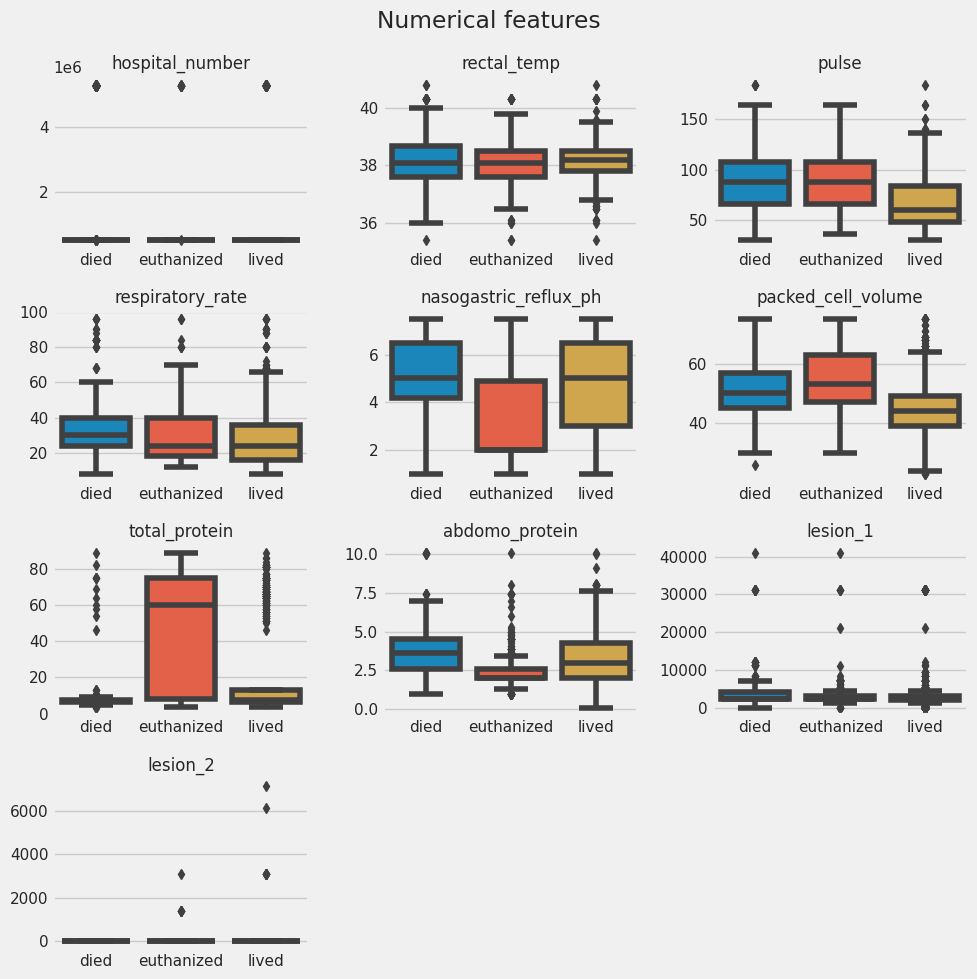

In [56]:
compute_numerical_plots(real_train_df)

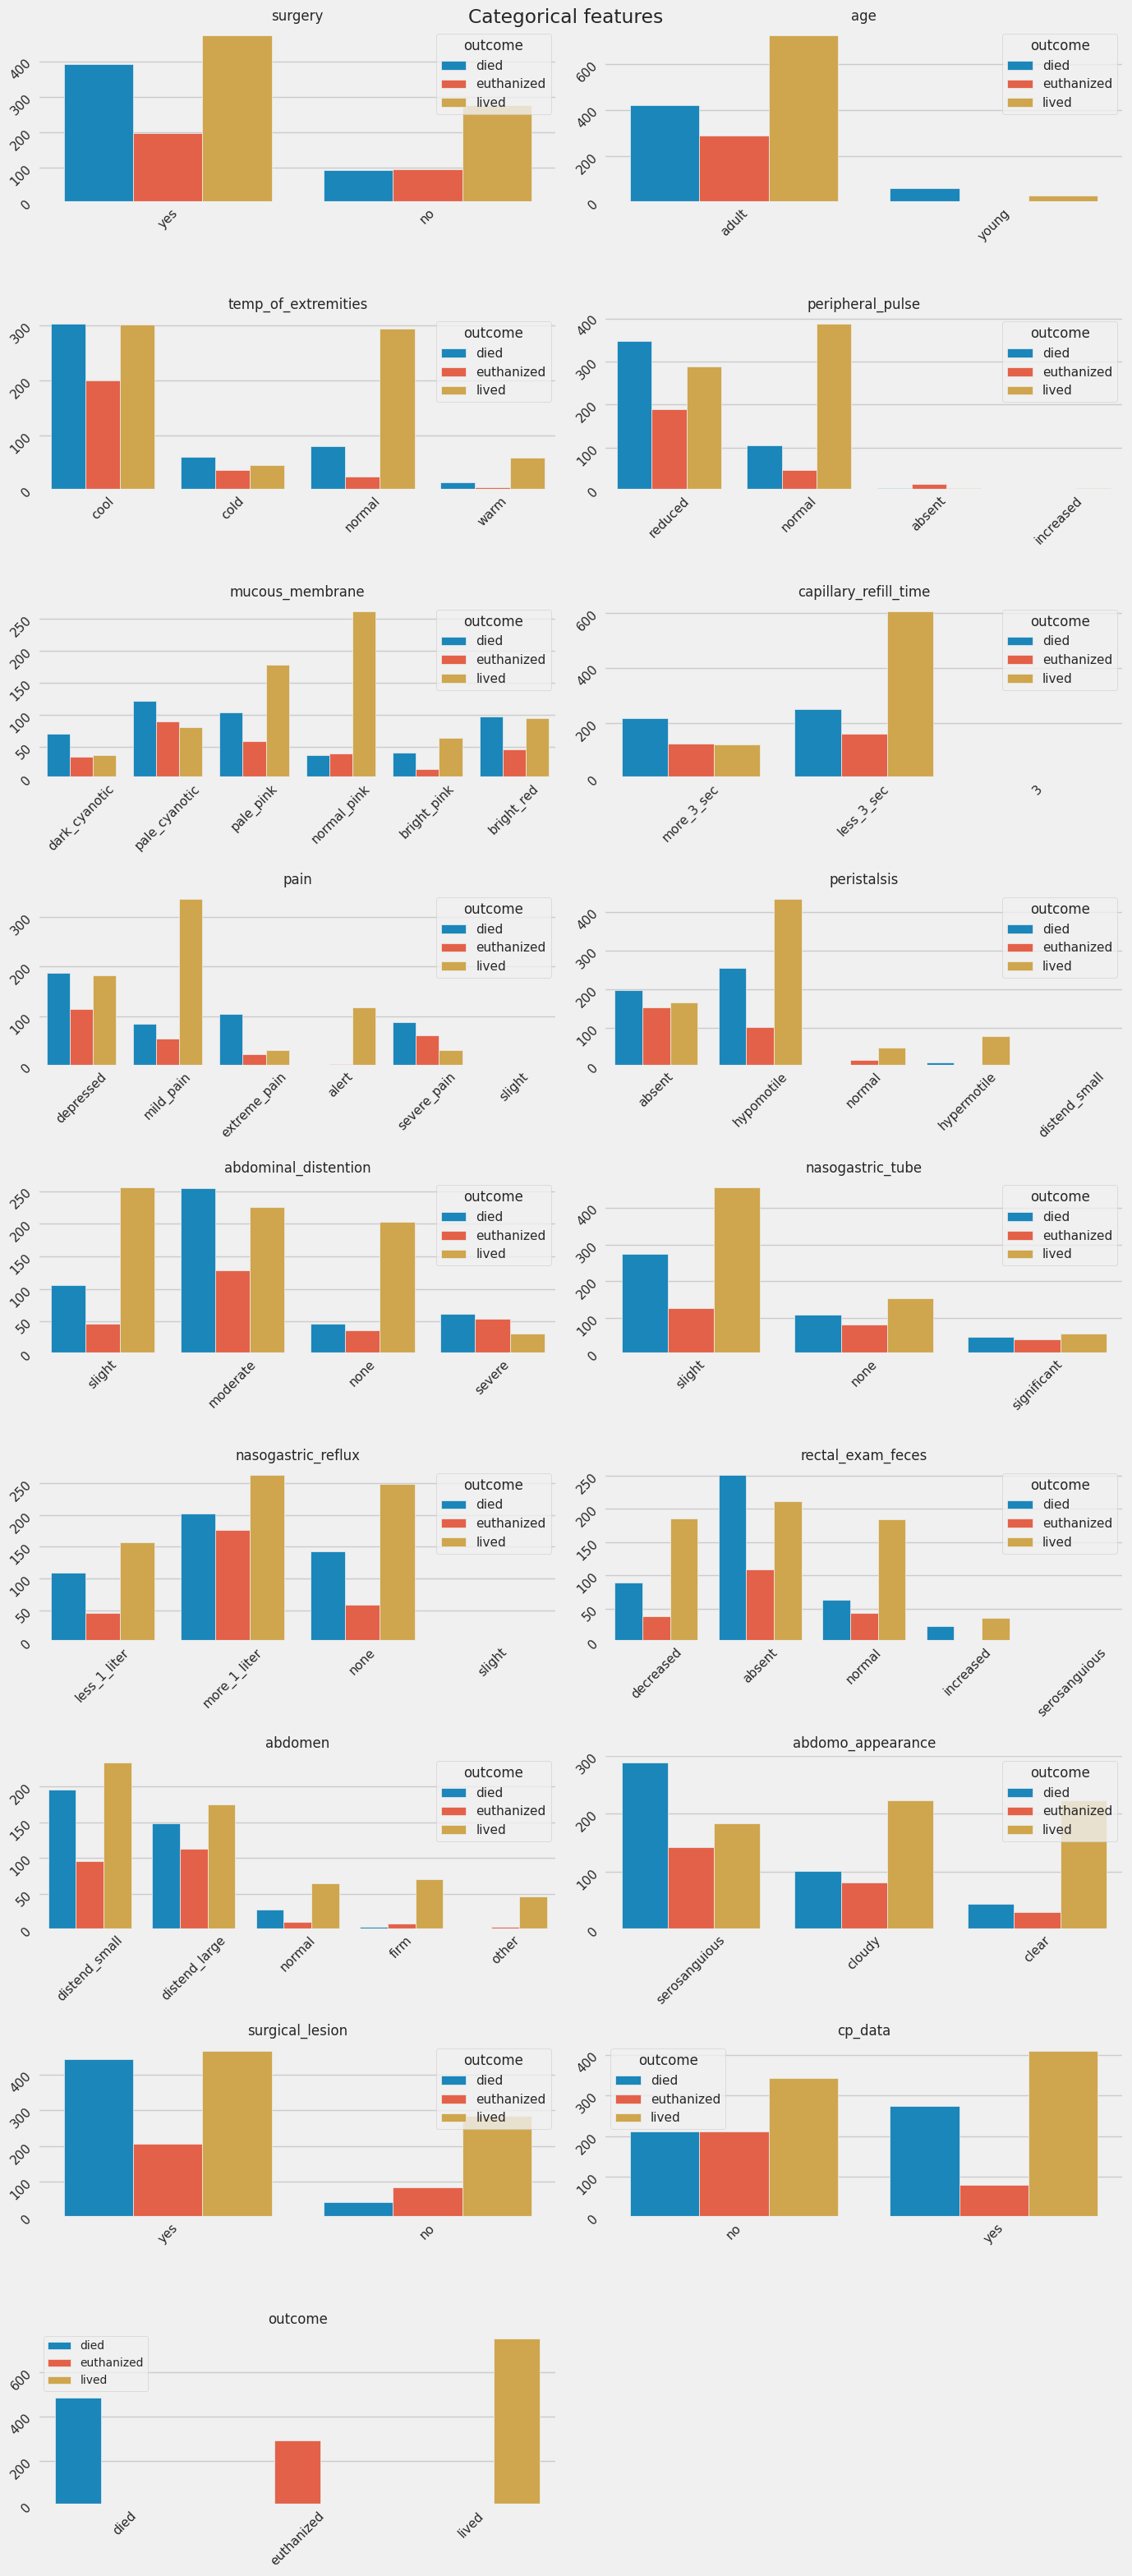

In [57]:
compute_categorical_plots(real_train_df)

/home/arrow/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 2000x2000 with 0 Axes>

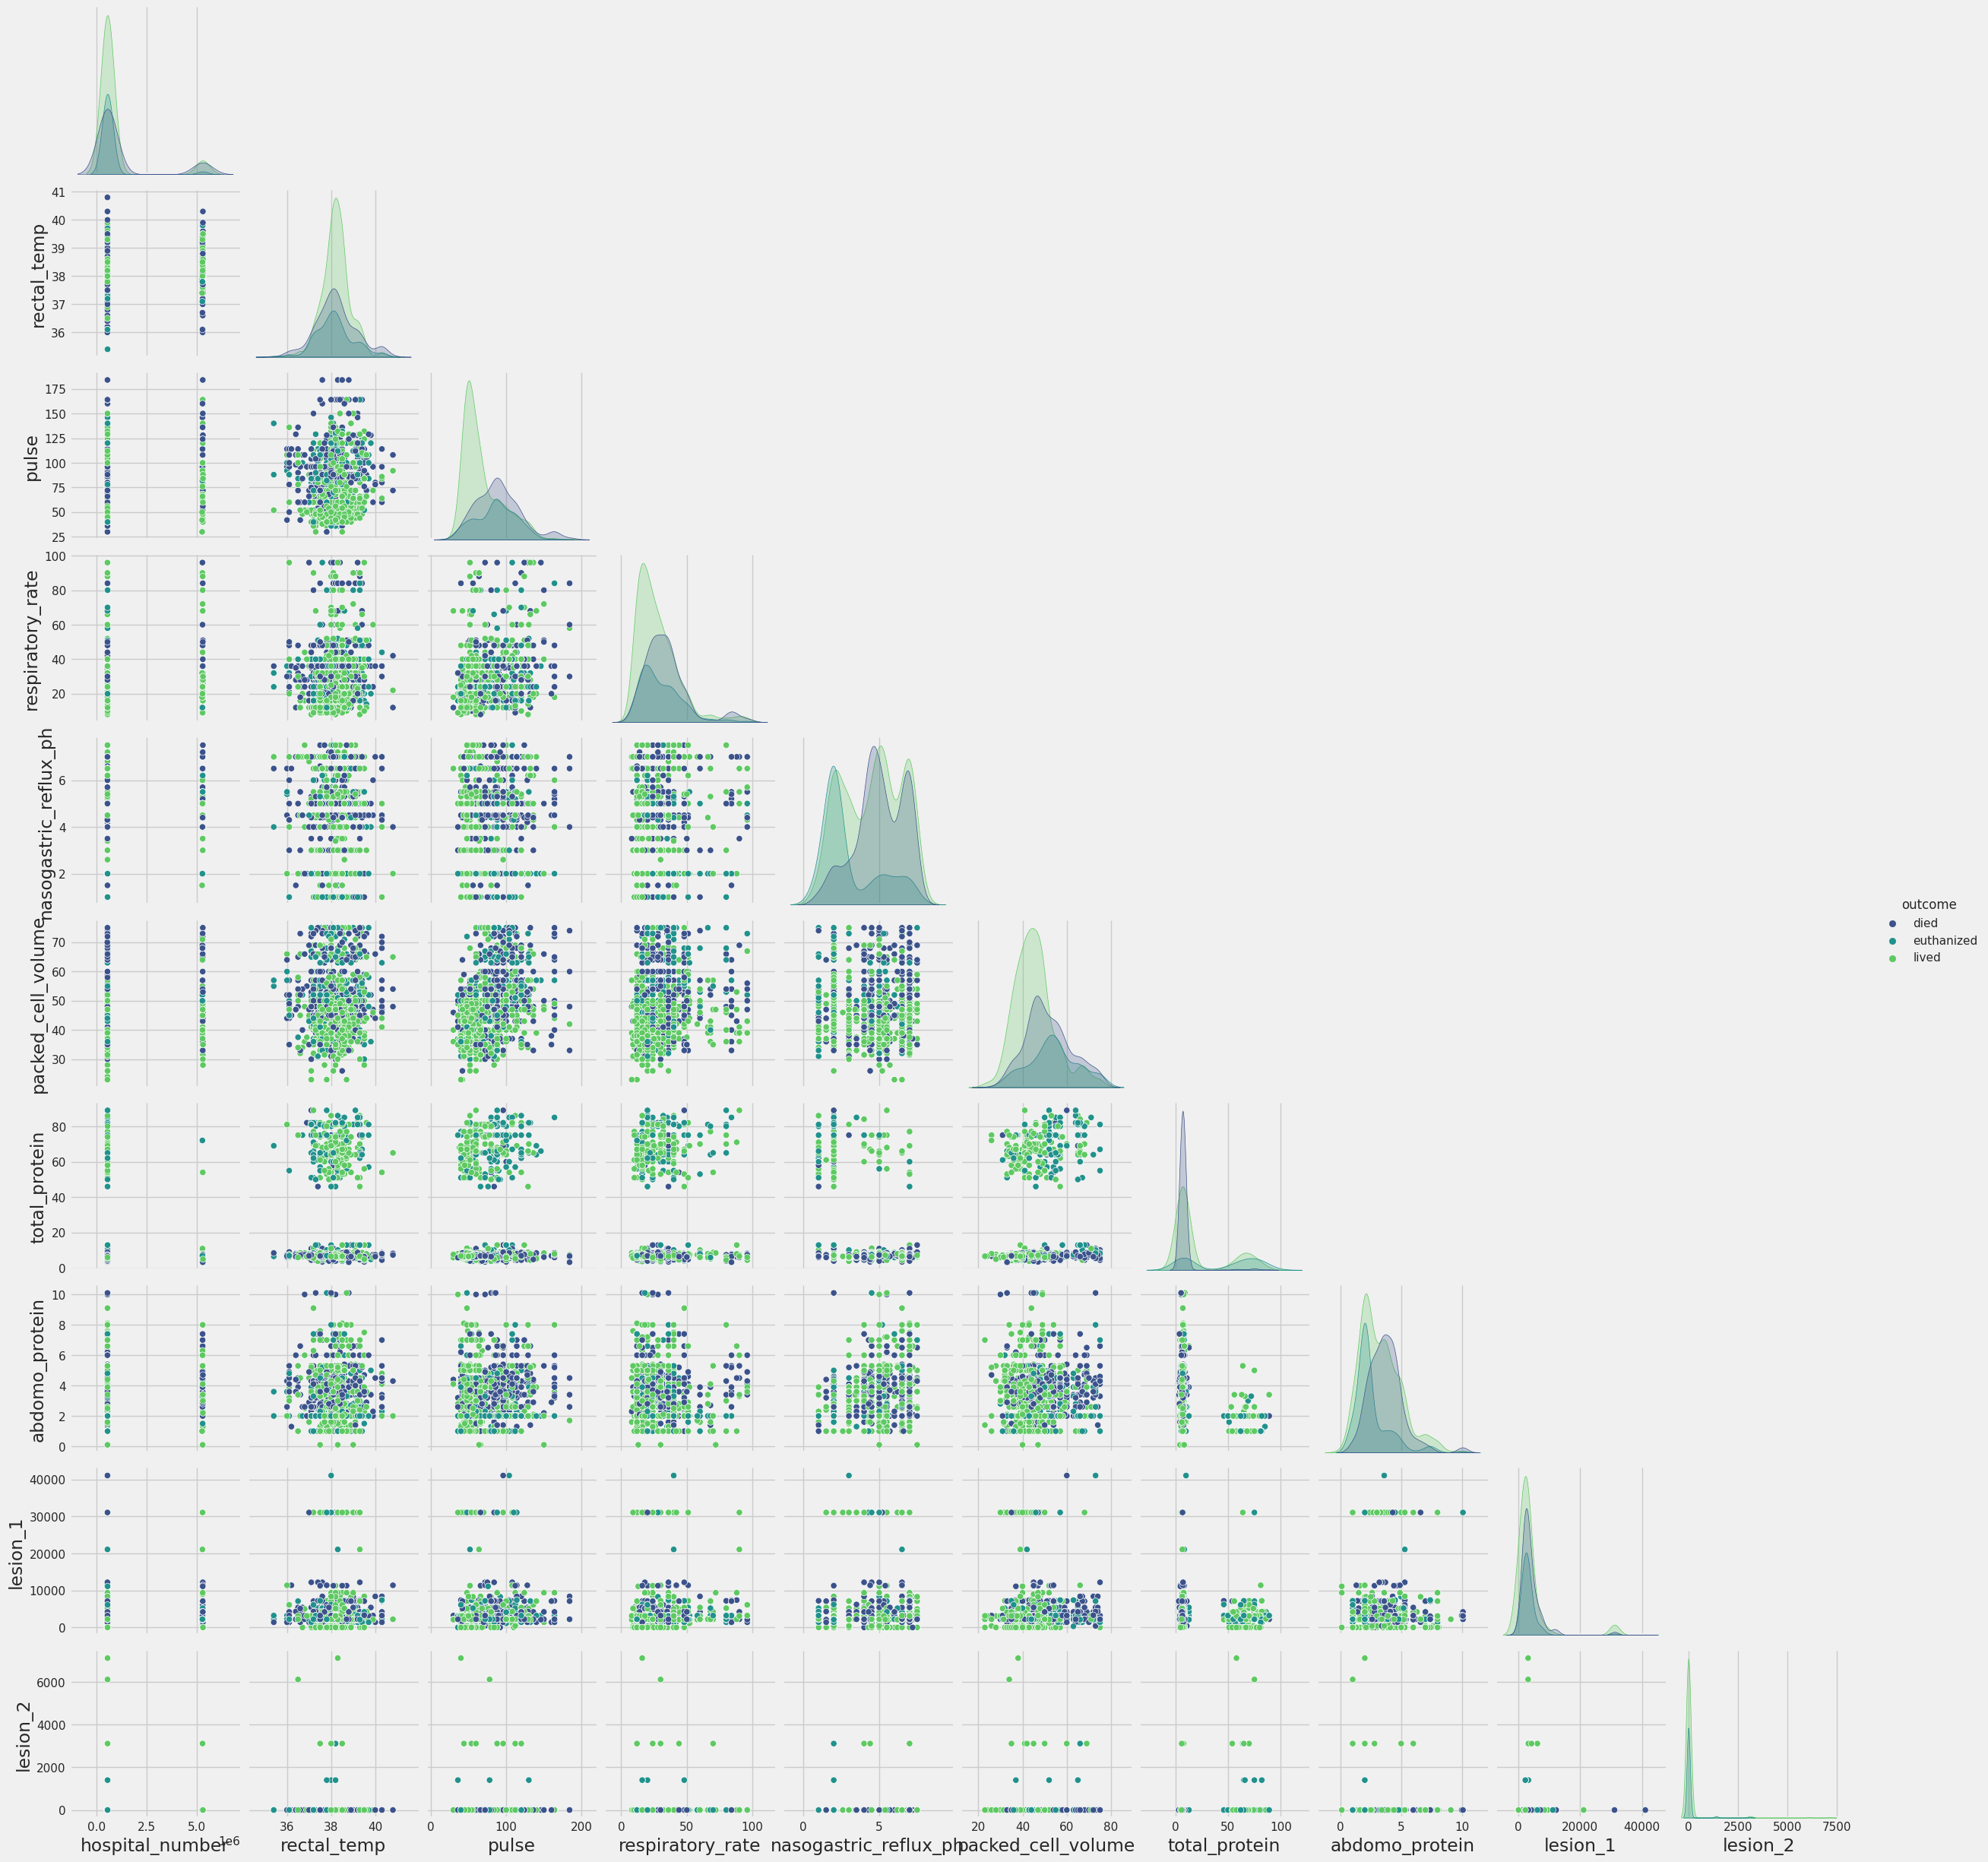

In [58]:
plt.figure(figsize=(20, 20))
sns.pairplot(data=real_train_df, hue="outcome", corner=True, palette="viridis")
plt.grid(None)
plt.show()

In [155]:
lesion_first_number = {
    "1": "gastric",
    "2": "sm_intestine",
    "3": "lg_colon",
    "4": "lg_colon_and_cecum",
    "5": "cecum",
    "6": "transverse_colon",
    "7": "retum/descending_colon",
    "8": "uterus",
    "9": "bladder",
    "11": "all_intestinal_sites",
    "00": "none",
}
lesion_second_number = {
    "1": "simple",
    "2": "strangulation",
    "3": "inflammation",
    "4": "other",
    "0": "none",
}
lesion_third_number = {
    "1": "mechanical",
    "2": "paralytic",
    "0": "none",
}
lesion_fourth_number = {
    "1": "obturation",
    "2": "intrinsic",
    "3": "extrinsic",
    "4": "adynamic",
    "5": "volvulus/torsion",
    "6": "intussuption",
    "7": "thromboembolic",
    "8": "hernia",
    "9": "lipoma/slenic_incarceration",
    "10": "displacement",
    "0": "none",
}


def IQR(col):
    q1 = np.percentile(col, 25)
    q3 = np.percentile(col, 75)
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    lower_outliers = col < lower_bound
    upper_outliers = col > upper_bound

    # col = np.where(lower_outliers, round(lower_bound, 3), col)
    col = np.where(upper_outliers, round(upper_bound, 3), col)
    return col


def lesion_split(s: str):
    if s[:2] in ["00", "11"]:
        first, second, third, fourth = s[:2], s[2], s[3], s[4]
    elif s[0] == "0":
        first, second, third, fourth = s[1], s[2], s[3], s[4]
    else:
        first, second, third, fourth = s[0], s[1], s[2], s[3:]

    return [
        lesion_first_number.get(first, "none"),
        lesion_second_number.get(second, "none"),
        lesion_third_number.get(third, "none"),
        lesion_fourth_number.get(fourth, "none"),
    ]


def preprocess_lesion(df, lesion: str):
    lesion_columns = [
        f"ENG{lesion}_site",
        f"ENG{lesion}_type",
        f"ENG{lesion}_subtype",
        f"ENG{lesion}_specific_code",
    ]
    split_lesion = split_lesion = (
        df[lesion].astype(str).str.zfill(5).apply(lesion_split)
    )
    lesion_df = pd.DataFrame(split_lesion.tolist(), columns=lesion_columns)
    df = pd.concat([df, lesion_df.set_index(df.index)], axis=1)
    df.drop(lesion, inplace=True, axis=1)
    return df


def preprocess(df):
    df = df.copy()

    df.loc[df["pain"] == "slight", "pain"] = "mild_pain"
    df.loc[df["pain"] == "moderate", "pain"] = "mild_pain"
    df["pain"].fillna("alert", inplace=True)
    pain_dict = {
        "alert": 10,
        "depressed": 20,
        "mild_pain": 30,
        "severe_pain": 40,
        "extreme_pain": 50,
    }
    df["pain"] = df["pain"].apply(lambda x: pain_dict[x])

    # distention_dict = {"none": 0, "slight": 10, "moderate": 20, "severe": 30}
    df["abdominal_distention"].fillna("none", inplace=True)
    # df["abdominal_distention"] = df["abdominal_distention"].apply(lambda x: distention_dict[x])

    df.loc[df["peristalsis"] == "distend_small", "peristalsis"] = "hypomotile"
    df.loc[df["nasogastric_reflux"] == "slight", "nasogastric_reflux"] = "more_1_liter"
    df.loc[
        df["rectal_exam_feces"] == "serosanguious", "rectal_exam_feces"
    ] = "increased"

    df.loc[df["capillary_refill_time"] == "more_3_sec", "capillary_refill_time"] = 5
    df.loc[df["capillary_refill_time"] == "less_3_sec", "capillary_refill_time"] = 1
    df.loc[df["capillary_refill_time"] == "3", "capillary_refill_time"] = 3
    df["capillary_refill_time"].fillna(3, inplace=True)

    df["nasogastric_reflux_ph"].fillna(3.5, inplace=True)

    df["respiratory_rate"] = IQR(df["respiratory_rate"])
    df = preprocess_lesion(df, "lesion_1")

    df["ENGDeviationFromNormalTemp"] = df["rectal_temp"].apply(lambda x: abs(x - 37.8))
    # df["ENGDeviationFromNormalReflux"] = df["nasogastric_reflux_ph"].apply(lambda x: abs(x - 3.5))
    df["ENGLesion2"] = df["lesion_2"].apply(lambda x: 1 if x > 0 else 0)
    # df["ENGPulse/RespiratoryRate"] = df["pulse"] / df["respiratory_rate"]
    # df["ENGCRT/Pulse"] = df["capillary_refill_time"] / df["pulse"]
    # df["ENGPainxPulse"] = df["pain"] * df["pulse"]
    # df["ENGTotalProtein/PCV"] = df["total_protein"] / df["packed_cell_volume"]
    # df["ENGDistension/Pulse"] = df["abdominal_distention"] / df["pulse"]

    df.drop("lesion_2", axis=1, inplace=True)
    # df.drop("respiratory_rate", axis=1, inplace=True)
    # df.drop("hospital_number", axis=1, inplace=True)

    return df

In [156]:
train_df = preprocess(real_train_df)
test_df = preprocess(real_test_df)
numerical_features = test_df.select_dtypes(include="number")
categorical_features = test_df.select_dtypes(exclude="number")

for feature in numerical_features:
    has_na = train_df[feature].isna().sum() + test_df[feature].isna().sum()
    if has_na:
        print(f'[Numerical] "{feature}" column has null values, filling with median')
    train_df[feature].fillna(train_df[feature].median(), inplace=True)
    test_df[feature].fillna(test_df[feature].median(), inplace=True)

for feature in categorical_features:
    has_na = train_df[feature].isna().sum() + test_df[feature].isna().sum()
    if has_na:
        print(f'[Categorical] "{feature}" column has null values, filling with mode')
    train_df[feature].fillna(train_df[feature].mode()[0], inplace=True)
    test_df[feature].fillna(test_df[feature].mode()[0], inplace=True)

label_encoders = {}
for feature in categorical_features:
    le = LabelEncoder()
    train_features = set(train_df[feature].values)
    test_features = set(test_df[feature].values)
    features = list(train_features.union(test_features))
    le.fit(features)
    train_df[feature] = le.transform(train_df[feature])
    test_df[feature] = le.transform(test_df[feature])
    label_encoders[feature] = le
le = LabelEncoder()
train_df[target_col] = le.fit_transform(train_df[target_col])
label_encoders[target_col] = le

[Numerical] "rectal_temp" column has null values, filling with median
[Numerical] "pulse" column has null values, filling with median
[Numerical] "respiratory_rate" column has null values, filling with median
[Numerical] "packed_cell_volume" column has null values, filling with median
[Numerical] "total_protein" column has null values, filling with median
[Numerical] "abdomo_protein" column has null values, filling with median
[Numerical] "ENGDeviationFromNormalTemp" column has null values, filling with median
[Categorical] "temp_of_extremities" column has null values, filling with mode
[Categorical] "peripheral_pulse" column has null values, filling with mode
[Categorical] "mucous_membrane" column has null values, filling with mode
[Categorical] "peristalsis" column has null values, filling with mode
[Categorical] "nasogastric_tube" column has null values, filling with mode
[Categorical] "nasogastric_reflux" column has null values, filling with mode
[Categorical] "rectal_exam_feces" c

In [157]:
get_basic_information(train_df).sort_values(by="nunique", ascending=False)

,count,nunique,null,type,count,mean,std,min,25%,50%,75%,max
hospital_number,1531,288,0,int64,1531.0,978239.474853,1.389757e+06,518476.0,528804.0,529827.0,534197.0,5305629.0
total_protein,1531,86,0,float64,1531.0,21.573024,2.659139e+01,3.3,6.6,7.5,10.6,89.0
abdomo_protein,1531,54,0,float64,1531.0,3.234226,1.511578e+00,0.1,2.0,3.0,3.9,10.1
pulse,1531,52,0,float64,1531.0,78.049641,2.885834e+01,30.0,52.0,72.0,96.0,184.0
packed_cell_volume,1531,50,0,float64,1531.0,48.998694,1.049617e+01,23.0,42.0,48.0,55.0,75.0
rectal_temp,1531,43,0,float64,1531.0,38.197061,7.644284e-01,35.4,37.8,38.2,38.5,40.8
ENGDeviationFromNormalTemp,1531,41,0,float64,1531.0,0.659373,5.573003e-01,0.0,0.3,0.5,0.8,3.0
respiratory_rate,1531,40,0,float64,1531.0,30.026127,1.628502e+01,8.0,18.0,28.0,36.0,96.0
nasogastric_reflux_ph,1531,26,0,float64,1531.0,4.252123,1.807476e+00,1.0,3.0,4.0,5.5,7.5
ENGlesion_1_specific_code,1531,11,0,int64,1531.0,6.372959,2.970887e+00,0.0,4.0,7.0,8.0,10.0


In [158]:
for feature in categorical_features:
    train = set(train_df[feature].values)
    test = set(test_df[feature].values)
    diff = train.symmetric_difference(test)
    if diff:
        print(feature)
        print([label_encoders[feature].inverse_transform([int(x)])[0] for x in diff])
        print()

In [159]:
def train(model, cv, x=None, y=None):
    if x is None:
        df = train_df.copy()
        x = df.drop(target_col, axis=1)
        y = df[target_col]

    pipeline = model
    train_scores = []
    val_scores = []

    for train_idx, val_idx in cv.split(x, y):
        x_train, x_val = x.iloc[train_idx].values, x.iloc[val_idx].values
        y_train, y_val = y.iloc[train_idx].values, y.iloc[val_idx].values
        pipeline.fit(x_train, y_train)

        train_preds = pipeline.predict(x_train)
        val_preds = pipeline.predict(x_val)
        train_score = f1_score(y_train, train_preds, average="micro")
        val_score = f1_score(y_val, val_preds, average="micro")
        train_scores.append(train_score)
        val_scores.append(val_score)

    return train_scores, val_scores


def predict(model, x_train=None, y_train=None, x_test=None):
    if x_train is None:
        df = train_df.copy()
        x_train = df.drop(target_col, axis=1)
        y_train = df[target_col]
        x_test = test_df.copy()

    name = model.__class__.__name__
    print(f"Training Model: {name}")
    pipeline = model
    pipeline.fit(x_train, y_train)

    train_preds = pipeline.predict(x_train)
    train_score = f1_score(y_train, train_preds, average="micro")
    print(f"Training score: {train_score:.3f}")

    test_preds = pipeline.predict(x_test)
    return test_preds


def train_voting_classifier(models, cross_validator):
    model = VotingClassifier(
        [(model.__class__.__name__, model) for model in models], voting="soft"
    )
    return train(model, cross_validator)


def predict_voting_classifier(models):
    model = VotingClassifier(
        [(model.__class__.__name__, model) for model in models], voting="soft"
    )
    return predict(model)


def predict_gridsearch():
    df = train_df.copy()
    x_train = df.drop(target_col, axis=1)
    y_train = df[target_col]

    model = CatBoostClassifier(verbose=0)
    params = {
        "iterations": [500, 1000],
        "l2_leaf_reg": np.logspace(-20, -19, 3),
        "leaf_estimation_iterations": [10],
        "learning_rate": [0.1, 0.05, 0.01],
        "random_seed": [42],
    }
    scorer = make_scorer(accuracy_score)
    g = GridSearchCV(
        estimator=model, param_grid=params, scoring=scorer, cv=5, verbose=2
    )

    g.fit(x_train, y_train)
    return g

In [160]:
seed = 1337
np.random.seed(seed)

models = [
    AdaBoostClassifier(random_state=seed),
    CatBoostClassifier(random_state=seed, verbose=0),
    ExtraTreesClassifier(random_state=seed),
    GradientBoostingClassifier(random_state=seed),
    HistGradientBoostingClassifier(random_state=seed),
    LGBMClassifier(random_state=seed),
    RandomForestClassifier(random_state=seed),
    XGBClassifier(random_state=seed),
]
skf_cv = StratifiedKFold(n_splits=5, random_state=seed, shuffle=True)

model_map = {model.__class__.__name__: model for model in models}

In [161]:
traindata_df = pd.DataFrame(
    columns=[
        "name",
        "mean_train",
        "std_train",
        "min_train",
        "max_train",
        "mean_val",
        "std_val",
        "min_val",
        "max_val",
        "train_scores",
        "val_scores",
        "model",
    ]
)

for model in models:
    name = model.__class__.__name__
    print(f"Training Model: {name}")
    train_scores, val_scores = train(model, skf_cv)

    mean_train, std_train, max_train, min_train = (
        np.mean(train_scores),
        np.std(train_scores),
        np.max(train_scores),
        np.min(train_scores),
    )
    mean_val, std_val, max_val, min_val = (
        np.mean(val_scores),
        np.std(val_scores),
        np.max(val_scores),
        np.min(val_scores),
    )

    print(
        f"  Training scores: {mean_train:.3f} ± {std_train:.3f}, Max: {max_train:.3f}, Min: {min_train:.3f}"
    )
    print(
        f"Validation scores: {mean_val:.3f} ± {std_val:.3f}, Max: {max_val:.3f}, Min: {min_val:.3f}"
    )
    print()

    data = {
        "name": name,
        "mean_train": mean_train,
        "std_train": std_train,
        "min_train": min_train,
        "max_train": max_train,
        "mean_val": mean_val,
        "std_val": std_val,
        "min_val": min_val,
        "max_val": max_val,
        "train_scores": train_scores,
        "val_scores": val_scores,
        "model": model,
    }
    data_df = pd.DataFrame([data])
    traindata_df = pd.concat([traindata_df, data_df])

traindata_df.reset_index(inplace=True)

Training Model: AdaBoostClassifier
  Training scores: 0.720 ± 0.006, Max: 0.727, Min: 0.713
Validation scores: 0.690 ± 0.033, Max: 0.742, Min: 0.660

Training Model: CatBoostClassifier
  Training scores: 1.000 ± 0.000, Max: 1.000, Min: 1.000
Validation scores: 0.744 ± 0.014, Max: 0.765, Min: 0.722

Training Model: ExtraTreesClassifier
  Training scores: 1.000 ± 0.000, Max: 1.000, Min: 1.000
Validation scores: 0.725 ± 0.014, Max: 0.745, Min: 0.704

Training Model: GradientBoostingClassifier
  Training scores: 0.900 ± 0.001, Max: 0.901, Min: 0.898
Validation scores: 0.743 ± 0.013, Max: 0.761, Min: 0.732

Training Model: HistGradientBoostingClassifier
  Training scores: 1.000 ± 0.000, Max: 1.000, Min: 1.000
Validation scores: 0.730 ± 0.013, Max: 0.748, Min: 0.710

Training Model: LGBMClassifier
  Training scores: 1.000 ± 0.000, Max: 1.000, Min: 1.000
Validation scores: 0.743 ± 0.007, Max: 0.752, Min: 0.735

Training Model: RandomForestClassifier
  Training scores: 1.000 ± 0.000, Max: 1.00

In [162]:
traindata_df.sort_values(by=["mean_val", "mean_train"], ascending=False, inplace=True)
traindata_df.reset_index(inplace=True)
traindata_df[
    [
        "name",
        "mean_train",
        "std_train",
        "min_train",
        "max_train",
        "mean_val",
        "std_val",
        "min_val",
        "max_val",
    ]
].T

,0,1,2,3,4,5,6,7
name,CatBoostClassifier,LGBMClassifier,GradientBoostingClassifier,XGBClassifier,HistGradientBoostingClassifier,ExtraTreesClassifier,RandomForestClassifier,AdaBoostClassifier
mean_train,1.0,1.0,0.899902,1.0,1.0,1.0,1.0,0.719792
std_train,0.0,0.0,0.001311,0.0,0.0,0.0,0.0,0.005677
min_train,1.0,1.0,0.897959,1.0,1.0,1.0,1.0,0.712653
max_train,1.0,1.0,0.901224,1.0,1.0,1.0,1.0,0.727124
mean_val,0.743953,0.743308,0.743297,0.738747,0.730255,0.72503,0.723719,0.689728
std_val,0.014203,0.006936,0.012657,0.020879,0.012871,0.013775,0.01313,0.03341
min_val,0.722222,0.735294,0.732026,0.715686,0.710098,0.703583,0.710098,0.660131
max_val,0.764706,0.751634,0.761438,0.771242,0.748366,0.745098,0.748366,0.74183


In [163]:
def plot_scores(df):
    df = df.copy()
    plt.figure(figsize=(8, 4))
    sns.barplot(
        data=df.reindex(df.sort_values(by="mean_val", ascending=False).index),
        x="mean_val",
        y="name",
        orient="h",
    )
    plt.title("Scores", size=20)
    plt.grid(None)
    plt.show()

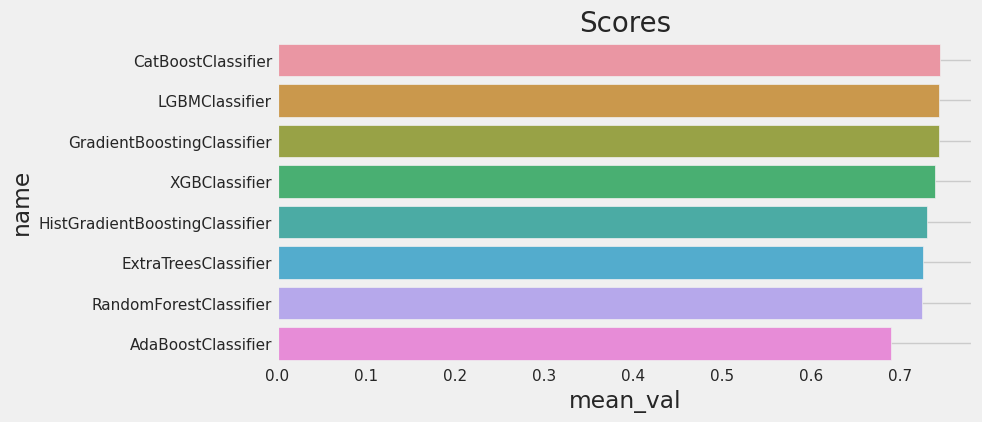

In [164]:
plot_scores(traindata_df)

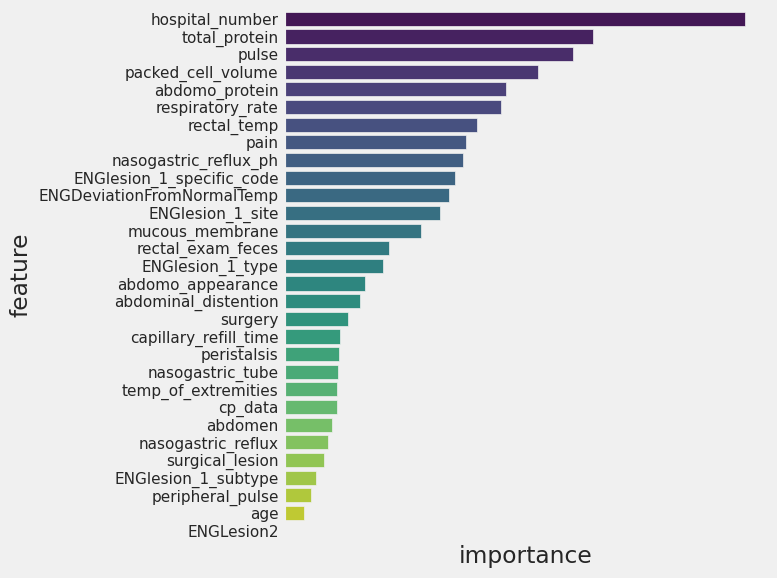

In [165]:
features = list(train_df.columns)
features.remove(target_col)
feature_importances = np.zeros((len(features)))

for model in list(traindata_df["model"]):
    if hasattr(model, "feature_importances_") and len(
        model.feature_importances_
    ) == len(features):
        feature_importances += model.feature_importances_

feature_df = pd.DataFrame({"feature": features, "importance": feature_importances})
feature_df.sort_values(by="importance", ascending=False, inplace=True)

plt.figure(figsize=(8, 6))
barplot = sns.barplot(data=feature_df, x="importance", y="feature", palette="viridis")
plt.xticks([])
plt.grid(False)
plt.tight_layout()
plt.show()

In [166]:
top_k = 3
submission_df = pd.read_csv("sample_submission.csv", index_col="id")
# submission_df[target_col] = predict(traindata_df["model"][0])
submission_df[target_col] = predict_voting_classifier(
    traindata_df["model"].values[:top_k]
)
submission_df[target_col] = label_encoders[target_col].inverse_transform(
    submission_df[target_col]
)

Training Model: VotingClassifier
Training score: 1.000


In [167]:
submission_df[target_col].value_counts()

lived         383
died          311
euthanized    130
Name: outcome, dtype: int64

In [145]:
submission_df.to_csv("notebook-v3-submission-v2.csv")

In [168]:
tp_lt_40_train_idxs = train_df[train_df["total_protein"] < 40].index
tp_ge_40_train_idxs = train_df[train_df["total_protein"] >= 40].index
tp_lt_40_test_idxs = test_df[test_df["total_protein"] < 40].index
tp_ge_40_test_idxs = test_df[test_df["total_protein"] >= 40].index

In [169]:
train_df_1 = train_df.loc[tp_lt_40_train_idxs]
train_df_2 = train_df.loc[tp_ge_40_train_idxs]
x_test_1 = test_df.loc[tp_lt_40_test_idxs]
x_test_2 = test_df.loc[tp_ge_40_test_idxs]

In [170]:
x_train_1 = train_df_1.drop(target_col, axis=1)
y_train_1 = train_df_1[target_col]
x_train_2 = train_df_2.drop(target_col, axis=1)
y_train_2 = train_df_2[target_col]

In [171]:
model_1 = CatBoostClassifier(random_state=seed, verbose=0)
model_2 = CatBoostClassifier(random_state=seed, verbose=0)
# models_1 = [
#     CatBoostClassifier(random_state=seed, verbose=0),
#     GradientBoostingClassifier(random_state=seed),
#     LGBMClassifier(random_state=seed),
# ]
# model_1 = VotingClassifier([(model.__class__.__name__, model) for model in models_1], voting="soft")
# models_2 = [
#     CatBoostClassifier(random_state=seed, verbose=0),
#     GradientBoostingClassifier(random_state=seed),
#     LGBMClassifier(random_state=seed),
# ]
# model_2 = VotingClassifier([(model.__class__.__name__, model) for model in models_2], voting="soft")

_, scores = train(model_1, skf_cv, x_train_1, y_train_1)
print(f"Mean: {np.mean(scores):.3f}, Std: {np.std(scores):.3f}")

_, scores = train(model_2, skf_cv, x_train_2, y_train_2)
print(f"Mean: {np.mean(scores):.3f}, Std: {np.std(scores):.3f}")

Mean: 0.720, Std: 0.017
Mean: 0.757, Std: 0.070


In [172]:
# model_1 = CatBoostClassifier(random_state=seed, verbose=0)
# model_2 = CatBoostClassifier(random_state=seed, verbose=0)

test_1_preds = predict(model_1, x_train_1, y_train_1, x_test_1).squeeze()
test_2_preds = predict(model_2, x_train_2, y_train_2, x_test_2).squeeze()

Training Model: CatBoostClassifier
Training score: 1.000
Training Model: CatBoostClassifier
Training score: 1.000


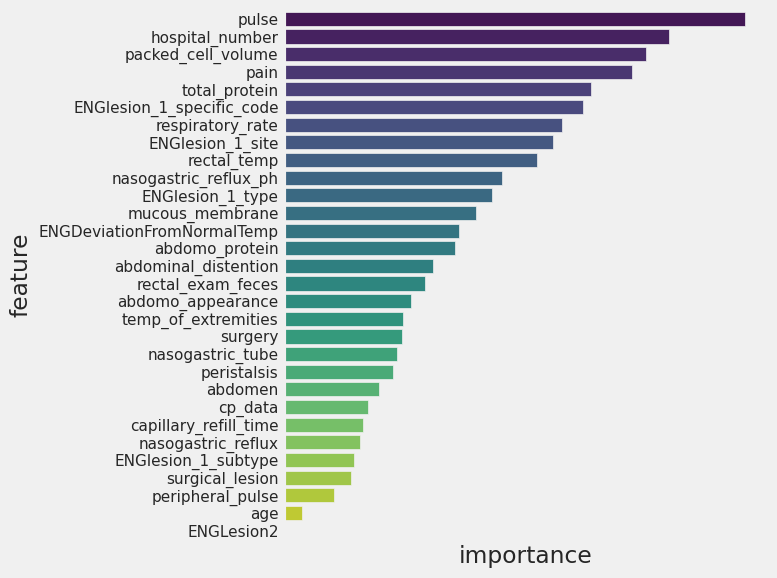

In [173]:
features = list(train_df.columns)
features.remove(target_col)
feature_importances = np.zeros((len(features)))

for model in [model_1, model_2]:
    feature_importances += model.feature_importances_

feature_df = pd.DataFrame({"feature": features, "importance": feature_importances})
feature_df.sort_values(by="importance", ascending=False, inplace=True)

plt.figure(figsize=(8, 6))
barplot = sns.barplot(data=feature_df, x="importance", y="feature", palette="viridis")
plt.xticks([])
plt.grid(False)
plt.tight_layout()
plt.show()

In [174]:
submission_df = pd.read_csv("sample_submission.csv", index_col="id")
submission_df.loc[tp_lt_40_test_idxs, target_col] = test_1_preds
submission_df.loc[tp_ge_40_test_idxs, target_col] = test_2_preds
submission_df[target_col] = label_encoders[target_col].inverse_transform(
    submission_df[target_col].astype(int)
)

In [175]:
submission_df[target_col].value_counts()

lived         385
died          318
euthanized    121
Name: outcome, dtype: int64

In [176]:
submission_df.to_csv("notebook-v3-submission-v8.csv")